# Exploring the simulation results

In [8]:
import pandas as pd
import numpy as np
import statistics

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab

from infant_abm.db_utils import load_run

params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (8, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

## Load and prepare the data

In [9]:
description_df, load_partial = load_run("results/boost_frequency")
display(description_df.head())


def get_success_step(index):
    results = load_partial(index).values()

    dists = [r["goal_dist"] for r in results]

    dists = np.array(dists)
    dists = np.nan_to_num(dists, nan=ITERATIONS)
    dists = np.average(dists, axis=0)

    try:
        return np.where(dists < SUCCESS_DIST)[0][0]
    except IndexError:
        return np.NaN


result = load_partial(0)

SUCCESS_DIST = 10
ITERATIONS = result["0"]["iterations"]
REPEATS = len(result)


results_df = description_df
results_df["success_steps"] = [get_success_step(index) for index in results_df.index]
# [get_success_step(index) for index in results_df.index]

results_df.head()

perception  persistence  coordination  persistence_boost_value  \
0         0.1          0.1      0.100000                      0.0   
1         0.1          0.1      0.100000                      0.3   
2         0.1          0.1      0.100000                      0.6   
3         0.1          0.1      0.100000                      1.0   
4         0.1          0.1      0.366667                      0.0   

   coordination_boost_value  
0                       0.0  
1                       0.3  
2                       0.6  
3                       1.0  
4                       0.0

perception  persistence  coordination  persistence_boost_value  \
0         0.1          0.1      0.100000                      0.0   
1         0.1          0.1      0.100000                      0.3   
2         0.1          0.1      0.100000                      0.6   
3         0.1          0.1      0.100000                      1.0   
4         0.1          0.1      0.366667                      0.0   

   coordination_boost_value  success_steps  
0                       0.0            NaN  
1                       0.3            NaN  
2                       0.6            NaN  
3                       1.0            NaN  
4                       0.0            NaN

In [3]:
def plot_params_3d(ax, x, y, z, title=None, coord_lim=[0, 1], s=40, **kwargs):
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim(coord_lim)

    ax.set_xlabel("perception", fontweight="bold")
    ax.set_ylabel("persistence", fontweight="bold")
    ax.set_zlabel("coordination", fontweight="bold")

    plot = ax.scatter3D(x, y, z, cmap=plt.get_cmap("viridis_r"), s=s, **kwargs)
    plt.title(title)

    ax.set_box_aspect(None, zoom=0.85)
    # ax.tick_params(axis="x", pad=30)

    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 10
    ax.zaxis.labelpad = 15

    return plot

In [4]:
def create_heatmap(
    heatmap_data,
    param1,
    param2,
    labelsx=None,
    labelsy=None,
    figsize=(6, 6),
    invert_colors=False,
    title="",
    show_text=True,
):
    show_ticks = labelsx is not None or labelsy is not None

    if show_ticks:
        assert heatmap_data.shape == (len(labelsy), len(labelsx))

    colormap_data = np.nan_to_num(heatmap_data, nan=(np.nanmax(heatmap_data) + 100))

    fig, ax = plt.subplots(figsize=figsize)

    if invert_colors:
        cmap = matplotlib.colormaps["viridis_r"]
    else:
        cmap = matplotlib.colormaps["viridis"]
    im = ax.imshow(colormap_data, cmap=cmap)

    # Show all ticks and label them with the respective list entries

    if labelsx is not None and labelsy is not None:
        ax.set_xticks(np.arange(len(labelsx)), labels=labelsx)
        ax.set_yticks(np.arange(len(labelsy)), labels=labelsy)

    ax.set_xlabel(param1)
    ax.set_ylabel(param2)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    if show_text and show_ticks:
        for i in range(len(labelsx)):
            for j in range(len(labelsy)):
                text = ax.text(
                    i,
                    j,
                    heatmap_data[j, i],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=11,
                )

    if not show_ticks:
        plt.axis("off")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

## Analyze boost improvement

In [ ]:
for row in results_df.groupby(by=["perception", "persistence", "coordination"]):
    print(row)

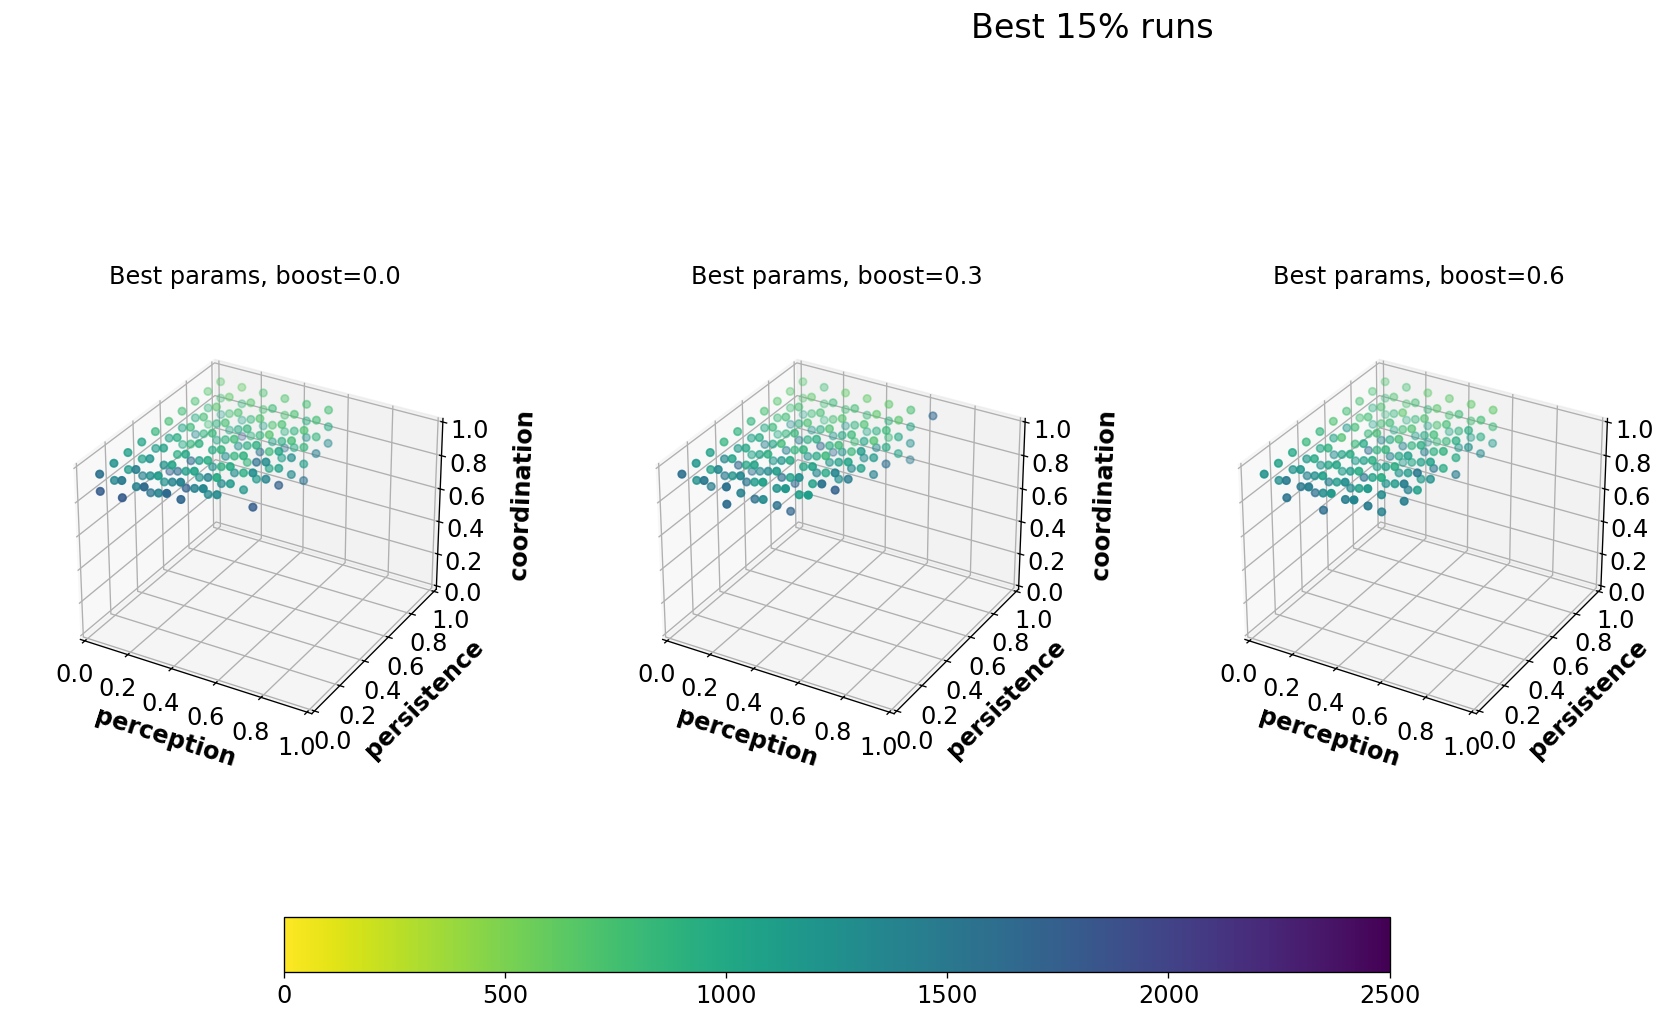

In [155]:
fig = plt.figure(figsize=(24, 10), dpi=120)

BEST_PERCENT = 15
BEST_N_POINTS = int(BEST_PERCENT / 100 * N_SAMPLES)

selected_df = [dataframes[i] for i in [0, 2, 4]]


for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[
            ["perception", "persistence", "coordination", "success_steps"]
        ]
        .to_numpy()
    )

    ax = fig.add_subplot(1, N_POINTS, i + 1, projection="3d")

    x, y, z, target = zip(*points)

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Best params, boost={boost_value}",
        c=target,
        s=20,
        vmin=0,
        vmax=1 / 8 * ITERATIONS,
    )

axes = fig.axes

fig.colorbar(plot, ax=axes, shrink=0.67, location="bottom")
fig.suptitle(f"Best {BEST_PERCENT}% runs", size="20")

plt.show()

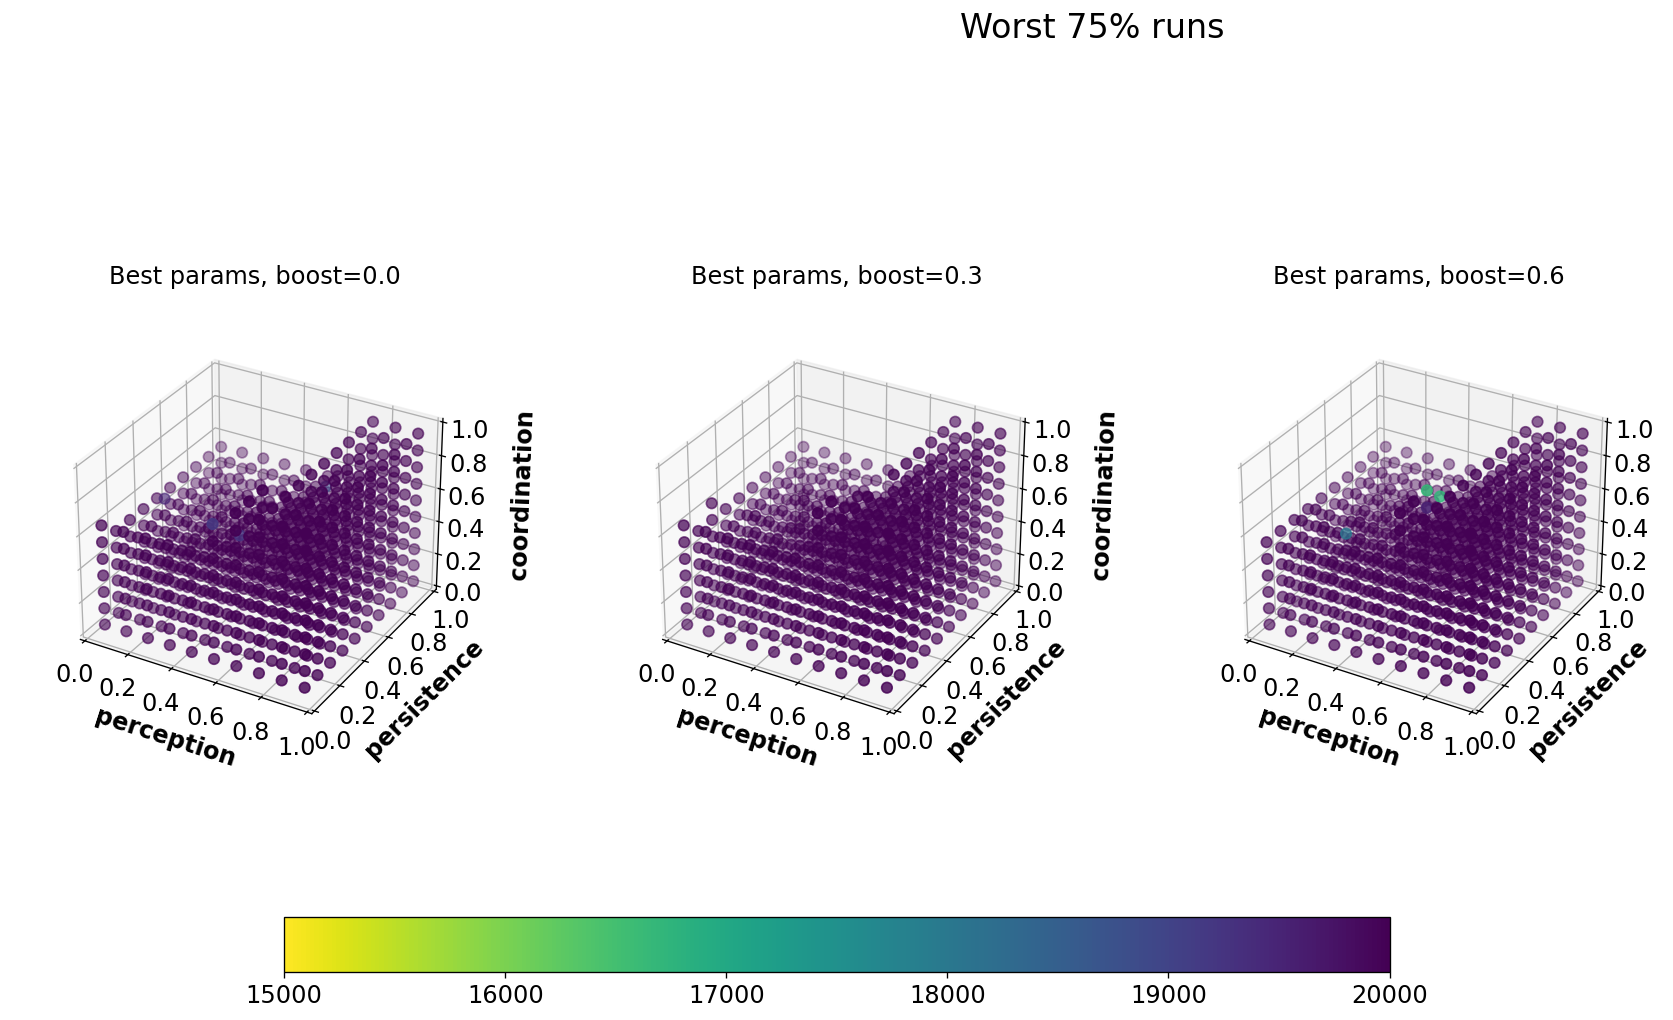

In [156]:
fig = plt.figure(figsize=(24, 10), dpi=120)

LAST_PERCENT = 75
LAST_N_POINTS = int(LAST_PERCENT / 100 * N_SAMPLES)

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    df["success_steps"] = df["success_steps"].fillna(ITERATIONS)

    points = (
        df.sort_values("success_steps")
        .tail(LAST_N_POINTS)[
            ["perception", "persistence", "coordination", "success_steps"]
        ]
        .to_numpy()
    )

    ax = fig.add_subplot(1, N_POINTS, i + 1, projection="3d")

    x, y, z, target = zip(*points)

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Best params, boost={boost_value}",
        c=target,
        vmin=3 / 4 * ITERATIONS,
        vmax=ITERATIONS,
    )

axes = fig.axes

cbar = fig.colorbar(plot, ax=axes, shrink=0.67, location="bottom")
fig.suptitle(f"Worst {LAST_PERCENT}% runs", size="20")
plt.show()

/var/folders/5f/kqrh3s354fl8g41k0s312pgh0000gn/T/ipykernel_14598/1418142149.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plot = ax.scatter3D(x, y, z, cmap=plt.get_cmap("viridis_r"), s=s, **kwargs)
/var/folders/5f/kqrh3s354fl8g41k0s312pgh0000gn/T/ipykernel_14598/1418142149.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plot = ax.scatter3D(x, y, z, cmap=plt.get_cmap("viridis_r"), s=s, **kwargs)


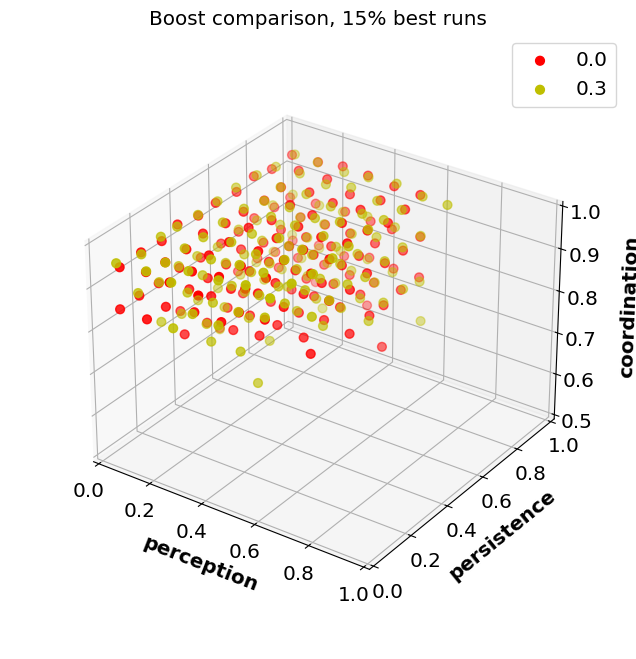

In [122]:
selected_df = [dataframes[i] for i in [0, 2]]
colors = ["r", "y", "b"]

JITTER = 0.008

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[["perception", "persistence", "coordination"]]
        .to_numpy()
    )

    x, y, z = zip(*points)

    x += np.random.uniform(-JITTER, JITTER, len(x))
    y += np.random.uniform(-JITTER, JITTER, len(y))
    z += np.random.uniform(-JITTER, JITTER, len(z))

    c = [colors[i] for _ in range(len(x))]

    plot = plot_params_3d(ax, x, y, z, coord_lim=[0.5, 1], color=c)
    plot.set_label(boost_value)

ax.set_title(f"Boost comparison, {BEST_PERCENT}% best runs")
ax.legend()
ax.view_init(30, -55)

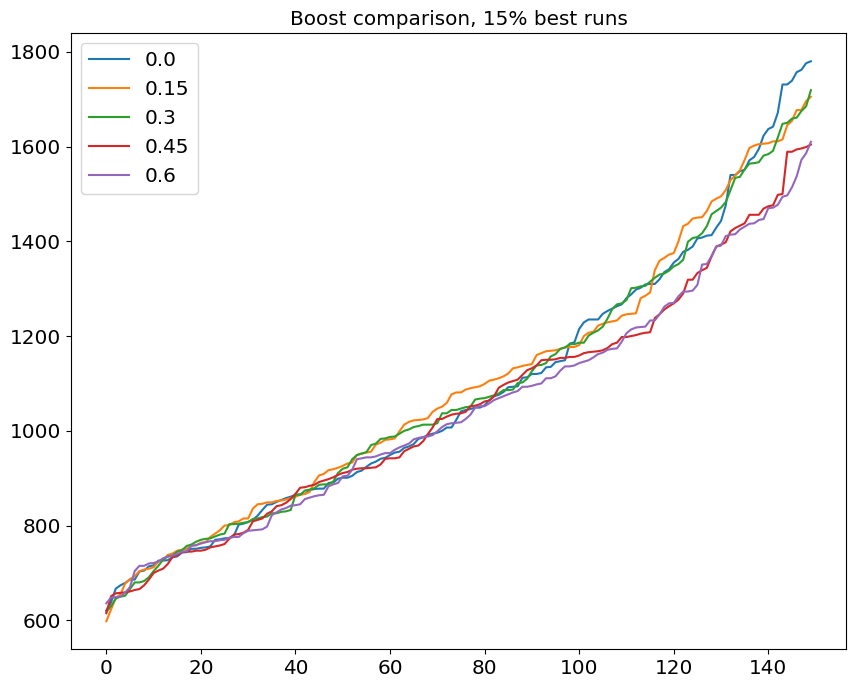

In [123]:
selected_df = [dataframes[i] for i in [0, 1, 2, 3, 4]]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[["success_steps"]]
        .to_numpy()
    )

    plot = ax.plot(np.arange(len(points)), points, label=boost_value)

ax.set_title(f"Boost comparison, {BEST_PERCENT}% best runs")
ax.legend()

### See in how many cases, the increase in boost value resulted in better results

{0.0: [677.3, 706.25, 780.66, 905.18], 0.15: [693.6, 740.65, 847.84, 961.91], 0.3: [709.2, 728.95, 814.3, 959.67], 0.45: [697.1, 721.85, 804.82, 937.44], 0.6: [720.2, 743.3, 820.18, 936.87]}


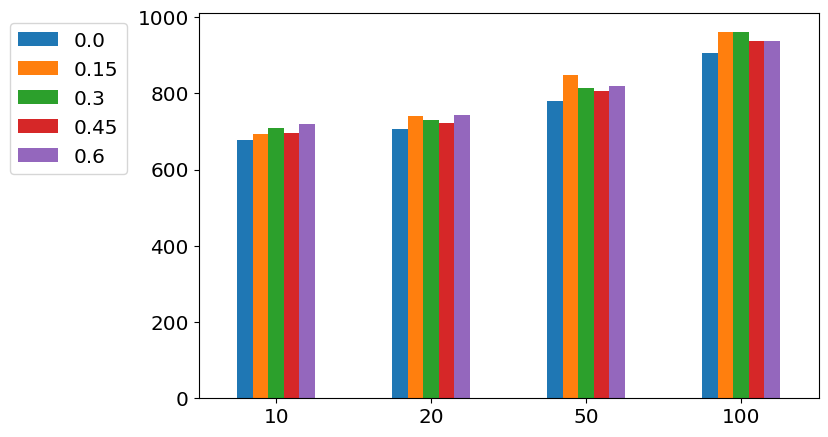

In [49]:
selected_df = [dataframes[i] for i in [1, 2, 3, 4]]
baseline_df = dataframes[0][1]

index = [10, 20, 50, 100]

plot_map = {0.0: []}

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)
    plot_map[boost_value] = []


for n_best_points in index:
    boost_cmp_df = baseline_df.sort_values("success_steps").head(n_best_points)[
        ["success_steps"]
    ]

    plot_map[0.0].append(np.average(boost_cmp_df["success_steps"]))

    for i, (name, df) in enumerate(selected_df):
        boost_value = np.round(int(name[-3:]) / 100, 2)

        boost_cmp_df[name] = df.iloc[baseline_df.index]["success_steps"]

        better_runs = len(
            boost_cmp_df[boost_cmp_df[name] > boost_cmp_df["success_steps"]]
        )
        plot_map[boost_value].append(np.average(boost_cmp_df[name]))

print(plot_map)
plot_df = pd.DataFrame(plot_map, index=index)
ax = plot_df.plot.bar(rot=0)
plt.legend(bbox_to_anchor=(-0.1, 1))

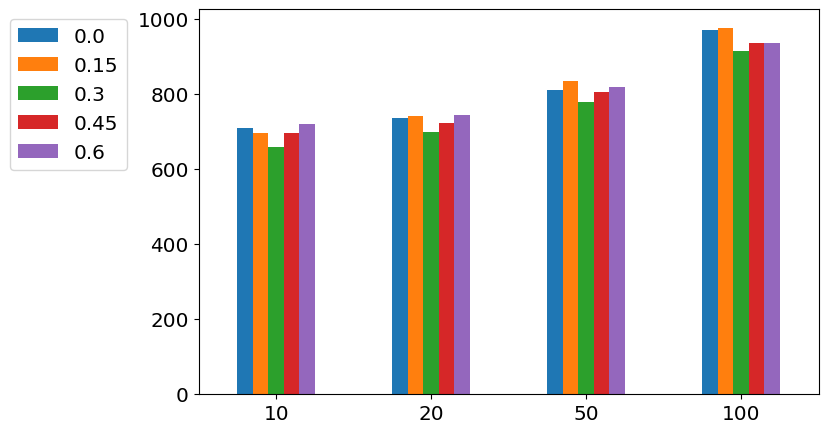

In [50]:
selected_df = [dataframes[i] for i in [0, 1, 2]]
baseline_df = dataframes[0][1]

index = [10, 20, 50, 100]

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)
    plot_map[boost_value] = []

for n_best_points in index:
    boost_cmp_df = df.sort_values("success_steps").head(n_best_points)[
        ["success_steps"]
    ]

    for i, (name, df) in enumerate(selected_df):
        boost_value = np.round(int(name[-3:]) / 100, 2)

        boost_cmp_df[name] = df.iloc[baseline_df.index]["success_steps"]

        better_runs = boost_cmp_df[
            boost_cmp_df[name] > boost_cmp_df["success_steps"]
        ].shape[0]
        plot_map[boost_value].append(np.average(boost_cmp_df[name]))


plot_df = pd.DataFrame(plot_map, index=index)
ax = plot_df.plot.bar(rot=0)
plt.legend(bbox_to_anchor=(-0.1, 1))

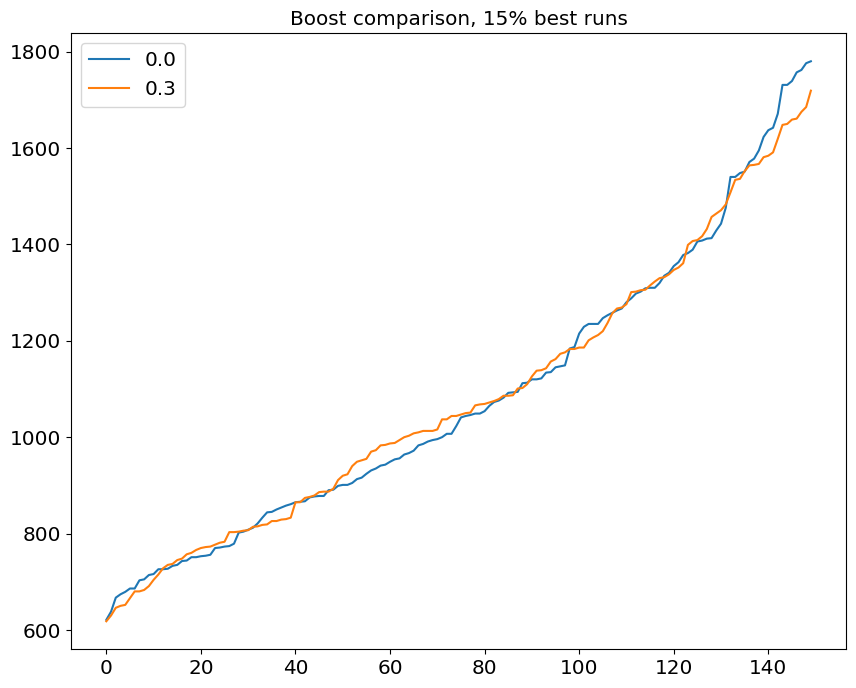

In [51]:
selected_df = [dataframes[i] for i in [0, 2]]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

for i, (name, df) in enumerate(selected_df):
    boost_value = np.round(int(name[-3:]) / 100, 2)

    points = (
        df.sort_values("success_steps")
        .head(BEST_N_POINTS)[["success_steps"]]
        .to_numpy()
    )

    plot = ax.plot(np.arange(len(points)), points, label=boost_value)

ax.set_title(f"Boost comparison, {BEST_PERCENT}% best runs")
ax.legend()

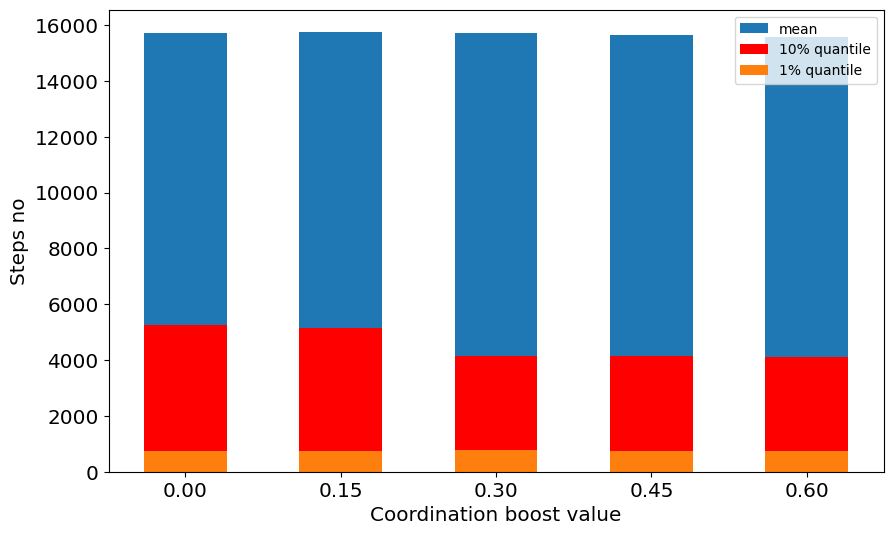

In [52]:
axis_x = []
y_mean = []
y_quantiles = np.zeros(shape=(len(dataframes), 99))

for i, (name, df) in enumerate(dataframes):
    axis_x.append(np.round(int(name[-3:]) / 100, 3))

    goal = df["success_steps"]
    goal = goal.fillna(ITERATIONS)

    y_mean.append(statistics.mean(goal))
    y_quantiles[i] = statistics.quantiles(goal, n=100)


f, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(axis_x, y_mean, width=0.08, label="mean")
ax1.set_xlabel("Coordination boost value")
ax1.set_ylabel("Steps no")

ax2 = plt.subplot()
ax2.bar(axis_x, y_quantiles[:, 20], width=0.08, label="10% quantile", color="r")
ax2.set_xticks(axis_x)

ax3 = plt.subplot()
ax3.bar(axis_x, y_quantiles[:, 1], width=0.08, label="1% quantile")
ax3.set_xticks(axis_x)
ax3.legend(prop={"size": 10})

results/basic_01_09_3/basic




perception  persistence  coordination  repeats  iterations  \
8          0.1          0.9           0.9        4       20000   
17         0.5          0.9           0.9        4       20000   
5          0.1          0.5           0.9        4       20000   
14         0.5          0.5           0.9        4       20000   
2          0.1          0.1           0.9        4       20000   
11         0.5          0.1           0.9        4       20000   

                                              actions  \
8   {'LookForToy': 8753, 'EvaluateToy': 18151, 'Cr...   
17  {'LookForToy': 8632, 'EvaluateToy': 18120, 'Cr...   
5   {'LookForToy': 8824, 'EvaluateToy': 19036, 'Cr...   
14  {'LookForToy': 8991, 'EvaluateToy': 19044, 'Cr...   
2   {'LookForToy': 9190, 'EvaluateToy': 19738, 'Cr...   
11  {'LookForToy': 8891, 'EvaluateToy': 19353, 'Cr...   

                                           infant_pos  success_steps  
8   ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          739.0  
17  ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          748.0  
5   ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          936.0  
14  ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...          997.0  
2   ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...         1305.0  
11  ([[50.0, 50.0], [50.0, 50.0], [50.0, 50.0], [5...         2125.0

success runs 6
Best: 739.0 Mean: 15809.25925925926


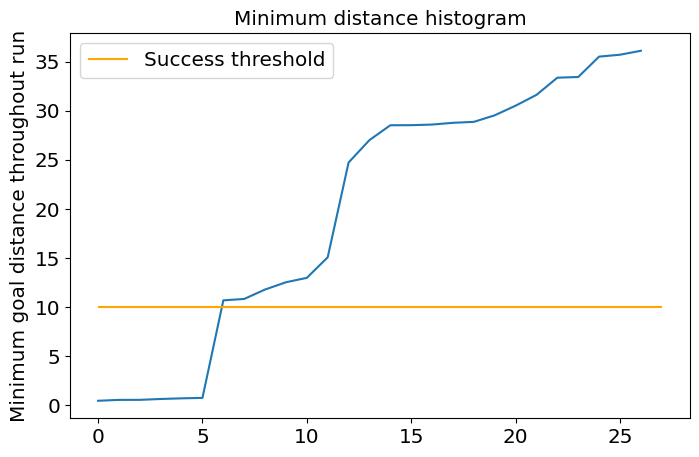

9


AssertionError: 

In [12]:
from statistics import mean

GRID_SIZE = 10


def draw_min_dist_histogram(df):
    y = (
        df.apply(lambda row: np.min(row["goal_distance"]), axis=1)
        .sort_values()
        .to_numpy()
    )

    fig, ax = plt.subplots()
    ax.plot(y)
    ax.set_title("Minimum distance histogram")
    ax.set_ylabel("Minimum goal distance throughout run")
    ax.hlines(
        y=SUCCESS_DIST, xmin=0, xmax=len(y), color="orange", label="Success threshold"
    )
    ax.legend()
    plt.show()


def get_heatmap_data(paramx, paramy, df):
    heatmap_data = np.zeros(shape=(GRID_SIZE, GRID_SIZE))
    # paramx = "perception"
    # paramy = "persistence"

    grouped = df_fill_na.groupby([paramy, paramx])
    # display(grouped.mean())

    # display(df_fill_na.sort_values(by=[paramx, paramy]))

    print(len(grouped))

    labelsx = []
    labelsy = []

    for idx, (name, group) in enumerate(grouped):
        # print(idx, idx // 5)

        value = group["success_steps"].mean()

        (p1, p2) = name

        if idx % GRID_SIZE == 0:
            labelsx.append(np.round(p1, 4))

        if idx // GRID_SIZE == 0:
            labelsy.append(np.round(p2, 4))

        heatmap_data[idx // GRID_SIZE, idx % GRID_SIZE] = value

    return labelsx, labelsy, heatmap_data


SUCCESS_DIST = 10

for name, df in dataframes:
    print(f"{name}\n\n")

    df["success_steps"] = df.apply(
        lambda row: get_success_step(row["goal_distance"], SUCCESS_DIST), axis=1
    )

    df_non_na = df[df["success_steps"].notnull()].sort_values(by=["success_steps"])
    display(
        df_non_na.head(10).drop(columns=["parent_tps", "infant_tps", "goal_distance"])
    )
    print(f"success runs {len(df_non_na)}")

    goal = df["success_steps"]
    goal = goal.fillna(ITERATIONS)
    best_result = sorted(goal)[0]

    print(f"Best: {best_result} Mean: {mean(goal)}")

    draw_min_dist_histogram(df)

    df_fill_na = df
    df_fill_na[["success_steps"]] = df[["success_steps"]].fillna(ITERATIONS)
    # display(df_fill_na)
    # grouped = df_fill_na.groupby(["perception", "persistence"])

    for paramx, paramy in [
        ("perception", "persistence"),
        ("perception", "coordination"),
        ("persistence", "coordination"),
    ]:
        labelsx, labelsy, heatmap_data = get_heatmap_data(paramx, paramy, df_fill_na)

        create_heatmap(
            heatmap_data,
            paramx,
            paramy,
            labelsx,
            labelsy,
            invert_colors=True,
            figsize=(8, 8),
        )

## Evaluate position trails

In [7]:
ordered_runs = results_df.sort_values("success_steps")
display(ordered_runs.head(5))
display(ordered_runs.tail(5))

perception  persistence  coordination  persistence_boost_value  \
62     0.100000          0.9           0.9                      0.6   
61     0.100000          0.9           0.9                      0.3   
126    0.366667          0.9           0.9                      0.6   
127    0.366667          0.9           0.9                      1.0   
125    0.366667          0.9           0.9                      0.3   

     coordination_boost_value  success_steps  
62                        0.6          688.0  
61                        0.3          717.0  
126                       0.6          740.0  
127                       1.0          750.0  
125                       0.3          754.0

perception  persistence  coordination  persistence_boost_value  \
251         0.9          0.9      0.633333                      1.0   
252         0.9          0.9      0.900000                      0.0   
253         0.9          0.9      0.900000                      0.3   
254         0.9          0.9      0.900000                      0.6   
255         0.9          0.9      0.900000                      1.0   

     coordination_boost_value  success_steps  
251                       1.0            NaN  
252                       0.0            NaN  
253                       0.3            NaN  
254                       0.6            NaN  
255                       1.0            NaN

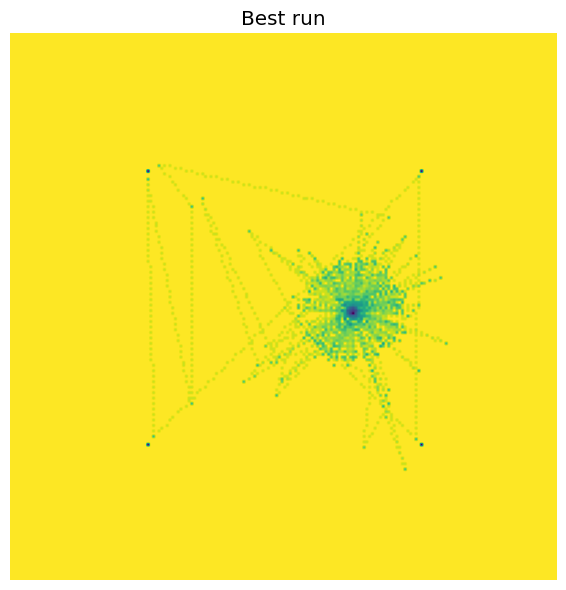

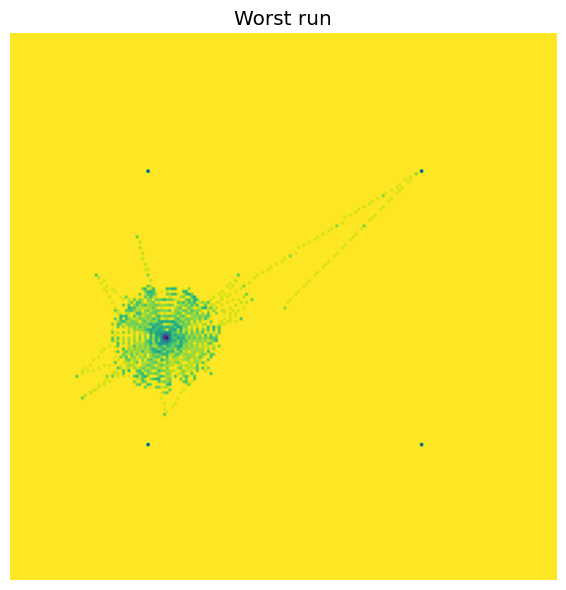

In [14]:
def create_run_position_heatmap(run_index, grid_size, title=""):
    positions = results[run_index][1].infant_positions
    positions = np.array(positions)

    pos_x = positions[:, 0]
    pos_y = positions[:, 1]

    heatmap_data = np.zeros(shape=(grid_size, grid_size))

    bins = np.linspace(0, 100, grid_size + 1)[1:-1]
    indices_x = np.digitize(pos_x, bins)
    indices_y = np.digitize(pos_y, bins)

    indices = zip(indices_x, indices_y)

    for idx in indices:
        heatmap_data[idx] += 1

    toy_value = np.max(heatmap_data)

    for t_x in [25, 75]:
        for t_y in [25, 75]:
            idx_x = np.digitize([t_x], bins)
            idx_y = np.digitize([t_y], bins)

            heatmap_data[idx_x, idx_y] += toy_value

    heatmap_data = np.log1p(heatmap_data)

    create_heatmap(
        heatmap_data,
        param1="x",
        param2="y",
        invert_colors=True,
        show_text=False,
        title=title,
        figsize=(6, 6),
    )


create_run_position_heatmap(ordered_runs.index[0], 200, title="Best run")
create_run_position_heatmap(ordered_runs.index[-1], 200, title="Worst run")

## Boost frequency

In [13]:
def get_boost_count(index, name):
    results = load_partial(index).values()

    boost_counts = [r[name] for r in results]

    boost_counts = np.array(boost_counts)
    return np.sum(boost_counts, axis=0)


for boost in [
    "persistence_boost_count",
    "no_persistence_boost_count",
    "coordination_boost_count",
    "no_coordination_boost_count",
]:
    if boost in results_df.columns:
        continue

    results_df[boost] = [get_boost_count(index, boost) for index in results_df.index]
# [get_success_step(index) for index in results_df.index]

results_df["persistence_boost_ratio"] = results_df["persistence_boost_count"] / (
    results_df["persistence_boost_count"] + results_df["no_persistence_boost_count"]
)

results_df["coordination_boost_ratio"] = results_df["coordination_boost_count"] / (
    results_df["coordination_boost_count"] + results_df["no_coordination_boost_count"]
)

display(results_df.sort_values("persistence_boost_ratio", ascending=False))
display(results_df.sort_values("coordination_boost_ratio", ascending=False))

perception  persistence  coordination  persistence_boost_value  \
252    0.900000     0.900000           0.9                      0.0   
239    0.900000     0.633333           0.9                      1.0   
238    0.900000     0.633333           0.9                      0.6   
253    0.900000     0.900000           0.9                      0.3   
254    0.900000     0.900000           0.9                      0.6   
..          ...          ...           ...                      ...   
83     0.366667     0.366667           0.1                      1.0   
2      0.100000     0.100000           0.1                      0.6   
66     0.366667     0.100000           0.1                      0.6   
67     0.366667     0.100000           0.1                      1.0   
3      0.100000     0.100000           0.1                      1.0   

     coordination_boost_value  success_steps  persistence_boost_count  \
252                       0.0            NaN                    25365   
239                       1.0            NaN                    25364   
238                       0.6            NaN                    25146   
253                       0.3            NaN                    24942   
254                       0.6            NaN                    25215   
..                        ...            ...                      ...   
83                        1.0            NaN                     4287   
2                         0.6            NaN                     5715   
66                        0.6            NaN                     5778   
67                        1.0            NaN                     4996   
3                         1.0            NaN                     4863   

     no_persistence_boost_count  coordination_boost_count  \
252                        3393                     24619   
239                        3461                     24561   
238                        3485                     24345   
253                        3467                     24011   
254                        3519                     24470   
..                          ...                       ...   
83                         3425                      1743   
2                          4664                      1247   
66                         4770                      1306   
67                         4638                      1246   
3                          4806                      1111   

     no_coordination_boost_count  persistence_boost_ratio  \
252                         4087                 0.882015   
239                         4091                 0.879931   
238                         4124                 0.878279   
253                         4354                 0.877961   
254                         4217                 0.877532   
..                           ...                      ...   
83                          2104                 0.555887   
2                           1217                 0.550631   
66                          1421                 0.547782   
67                          1440                 0.518580   
3                           1287                 0.502948   

     coordination_boost_ratio  
252                  0.857626  
239                  0.857218  
238                  0.855141  
253                  0.846501  
254                  0.853000  
..                        ...  
83                   0.453080  
2                    0.506088  
66                   0.478915  
67                   0.463887  
3                    0.463303  

[256 rows x 12 columns]

perception  persistence  coordination  persistence_boost_value  \
252    0.900000     0.900000           0.9                      0.0   
222    0.900000     0.366667           0.9                      0.6   
239    0.900000     0.633333           0.9                      1.0   
204    0.900000     0.100000           0.9                      0.0   
223    0.900000     0.366667           0.9                      1.0   
..          ...          ...           ...                      ...   
51     0.100000     0.900000           0.1                      1.0   
113    0.366667     0.900000           0.1                      0.3   
48     0.100000     0.900000           0.1                      0.0   
112    0.366667     0.900000           0.1                      0.0   
49     0.100000     0.900000           0.1                      0.3   

     coordination_boost_value  success_steps  persistence_boost_count  \
252                       0.0            NaN                    25365   
222                       0.6            NaN                    25234   
239                       1.0            NaN                    25364   
204                       0.0            NaN                    25283   
223                       1.0            NaN                    25163   
..                        ...            ...                      ...   
51                        1.0            NaN                     3754   
113                       0.3            NaN                     3553   
48                        0.0            NaN                     3663   
112                       0.0            NaN                     3662   
49                        0.3            NaN                     3515   

     no_persistence_boost_count  coordination_boost_count  \
252                        3393                     24619   
222                        3589                     24369   
239                        3461                     24561   
204                        3970                     23347   
223                        3573                     24319   
..                          ...                       ...   
51                         1844                      2158   
113                        1758                      2003   
48                         1800                      2051   
112                        1811                      2070   
49                         1829                      1940   

     no_coordination_boost_count  persistence_boost_ratio  \
252                         4087                 0.882015   
222                         4051                 0.875481   
239                         4091                 0.879931   
204                         3907                 0.864287   
223                         4086                 0.875661   
..                           ...                      ...   
51                          2923                 0.670597   
113                         2770                 0.668989   
48                          2902                 0.670511   
112                         2940                 0.669103   
49                          2915                 0.657747   

     coordination_boost_ratio  
252                  0.857626  
222                  0.857460  
239                  0.857218  
204                  0.856645  
223                  0.856152  
..                        ...  
51                   0.424720  
113                  0.419652  
48                   0.414092  
112                  0.413174  
49                   0.399588  

[256 rows x 12 columns]

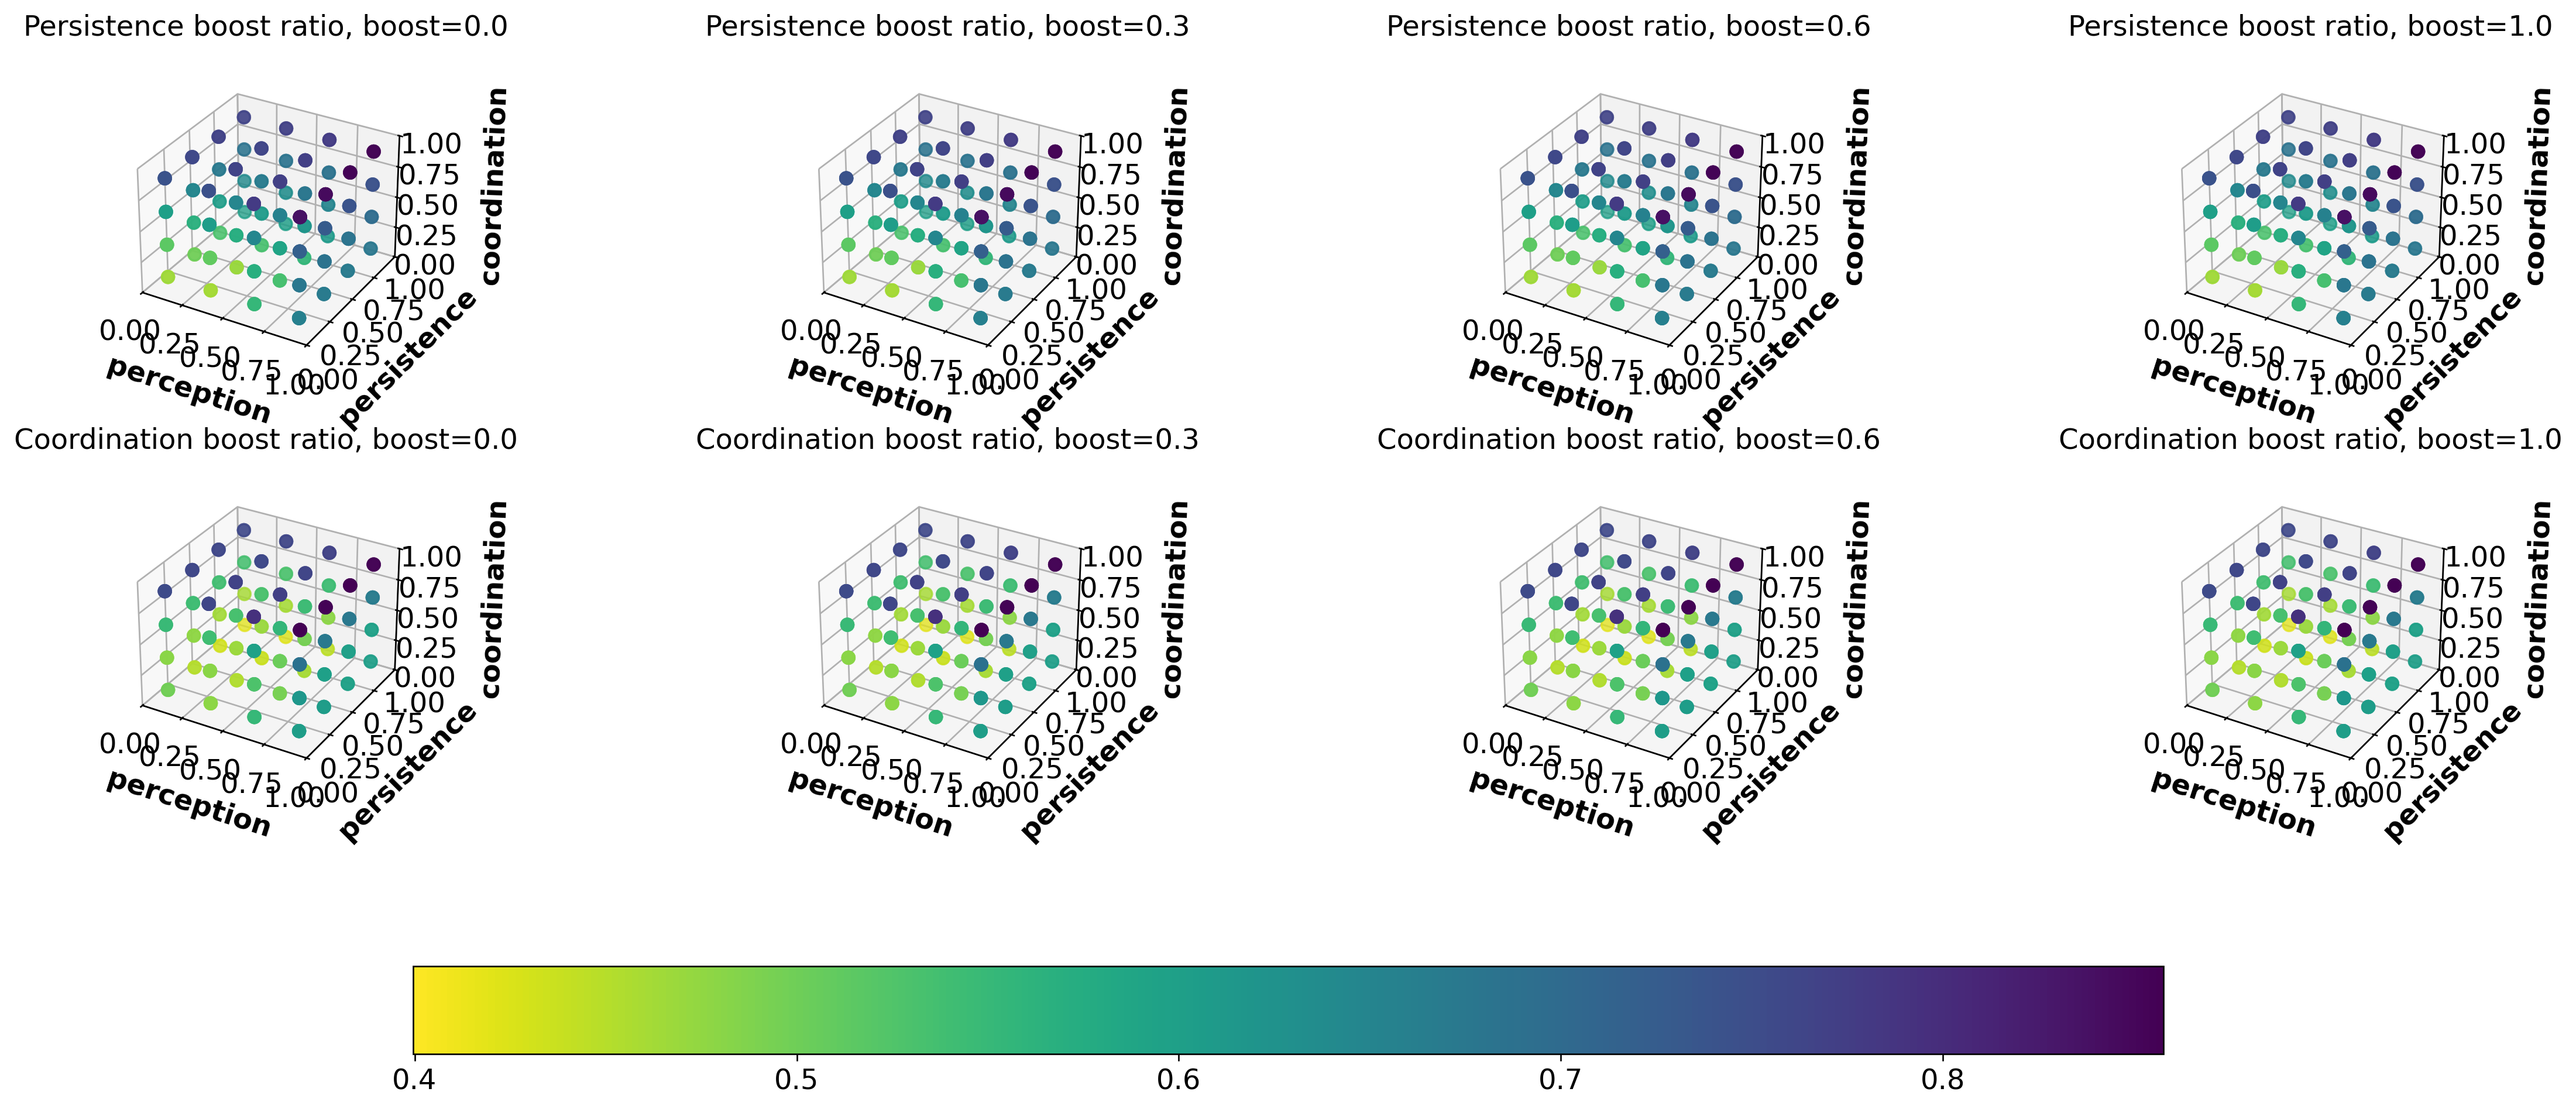

In [28]:
fig = plt.figure(figsize=(24, 10), dpi=240)

boost_values = results_df["persistence_boost_value"].unique()
N_COLS = len(boost_values)

for i, boost_value in enumerate(boost_values):
    boost_value = np.round(boost_value, 2)

    df = results_df
    df["success_steps"] = df["success_steps"].fillna(ITERATIONS)

    points = df.sort_values("success_steps")[
        [
            "perception",
            "persistence",
            "coordination",
            "persistence_boost_ratio",
            "coordination_boost_ratio",
        ]
    ].to_numpy()

    x, y, z, b_persist, b_coord = zip(*points)

    ax = fig.add_subplot(2, N_COLS, i + 1, projection="3d")

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Persistence boost ratio, boost={boost_value}",
        c=b_persist,
        # vmin=3 / 4 * ITERATIONS,
        # vmax=ITERATIONS,
    )

    ax = fig.add_subplot(2, N_COLS, N_COLS + i + 1, projection="3d")

    plot = plot_params_3d(
        ax,
        x,
        y,
        z,
        title=f"Coordination boost ratio, boost={boost_value}",
        c=b_coord,
        # vmin=3 / 4 * ITERATIONS,
        # vmax=ITERATIONS,
    )

axes = fig.axes

cbar = fig.colorbar(plot, ax=axes, shrink=0.67, location="bottom")
# fig.suptitle(f"Worst {LAST_PERCENT}% runs", size="20")
plt.show()

perception                         0.500000
persistence                        0.500000
coordination                       0.500000
persistence_boost_value            0.000000
coordination_boost_value           0.000000
success_steps                  14161.843750
persistence_boost_count        11913.328125
no_persistence_boost_count      4023.828125
coordination_boost_count        8977.625000
no_coordination_boost_count     4586.062500
persistence_boost_ratio            0.719518
coordination_boost_ratio           0.593470
dtype: float64
perception                         0.500000
persistence                        0.500000
coordination                       0.500000
persistence_boost_value            0.300000
coordination_boost_value           0.300000
success_steps                  14201.218750
persistence_boost_count        11973.890625
no_persistence_boost_count      4041.640625
coordination_boost_count        9006.718750
no_coordination_boost_count     4576.593750
persistence_boost

(0.5814173753092144, 0.6041435134085302)

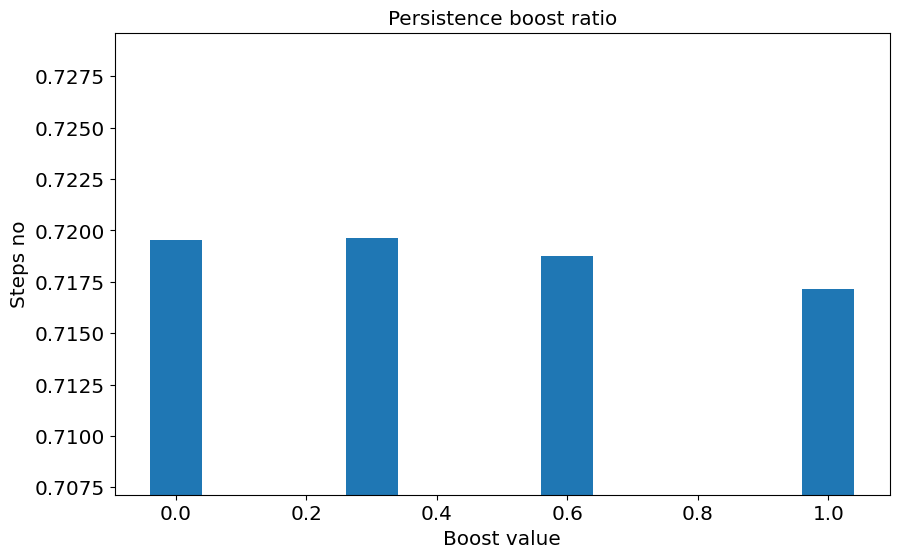

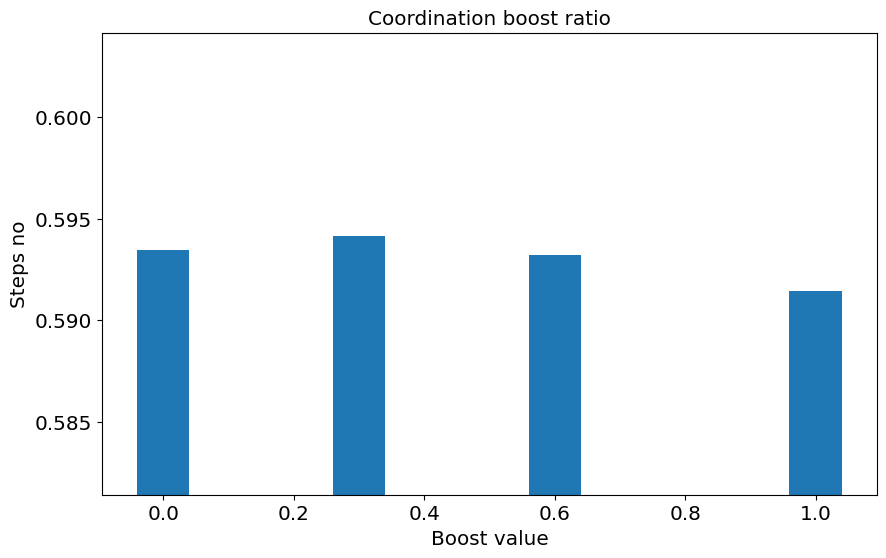

In [37]:
axis_x = []
persistence_boost_ratios = []
coordination_boost_ratios = []

for boost_value, row in results_df.groupby(by="persistence_boost_value"):
    axis_x.append(np.round(boost_value, 3))

    row = row.mean()

    print(row)

    persistence_boost_ratios.append(row["persistence_boost_ratio"])
    coordination_boost_ratios.append(row["coordination_boost_ratio"])


f, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(
    axis_x,
    persistence_boost_ratios,
    width=0.08,
)
ax1.set_xlabel("Boost value")
ax1.set_ylabel("Steps no")
ax1.set_title("Persistence boost ratio")
ax1.set_ylim(
    bottom=min(persistence_boost_ratios) - 0.01,
    top=max(persistence_boost_ratios) + 0.01,
)

f2, ax2 = plt.subplots(figsize=(10, 6))
ax2.bar(
    axis_x,
    coordination_boost_ratios,
    width=0.08,
)
ax2.set_xlabel("Boost value")
ax2.set_ylabel("Steps no")
ax2.set_title("Coordination boost ratio")
ax2.set_ylim(
    bottom=min(coordination_boost_ratios) - 0.01,
    top=max(coordination_boost_ratios) + 0.01,
)

## Moving average

In [116]:
def moving_average(a, n=3):
    # Add zeros at the beginning, so the result doesn't change dimensions
    a = np.concatenate([([0] * (n - 1)), a])

    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


def visualize_run(run, average_steps=500, extra_title=""):
    x = list(range(run["iterations"]))

    step_stats = run["goal_distance"]
    parent_stats = run["parent_tps"]
    infant_stats = run["infant_tps"]

    parent_stats = moving_average(parent_stats, average_steps)
    infant_stats = moving_average(infant_stats, average_steps)

    fig, ax1 = plt.subplots()

    ax1.plot(x, step_stats, color="r")
    ax1.set_ylim(bottom=0, top=50)
    ax1.set_ylabel("toy distance")
    ax1.set_xlabel("step")

    title = f'perc={run["perception"]:.2f}, pers={run["persistence"]:.2f}, \
coord={run["coordination"]:.2f},\n\
avg for {run["repeats"]} runs'

    if extra_title != "":
        title = extra_title + "\n" + title

    ax1.set_title(title)
    ax1.legend(["toy distance"], loc="lower right")

    ax2 = ax1.twinx()
    ax2.plot(x, parent_stats, color="b")
    ax2.set_ylabel("TPS")

    ax2.plot(x, infant_stats, color="orange")
    ax2.set_ylim(bottom=0)

    ax2.axvline(x=average_steps - 1, color="grey", label="axvline - full height")
    ax2.legend(["parent TPS", "infant TPS"], loc="upper right")

    x_ticks = np.append(ax1.get_xticks()[1:-1], average_steps)
    ax1.set_xticks(x_ticks)
    ax2.set_xticks(x_ticks)

    fig.tight_layout()
    # plt.savefig(f'../../plots/big_{current_param}.png', dpi=300)
    plt.show()

### Show a couple of randomly selected runs and see how they performed

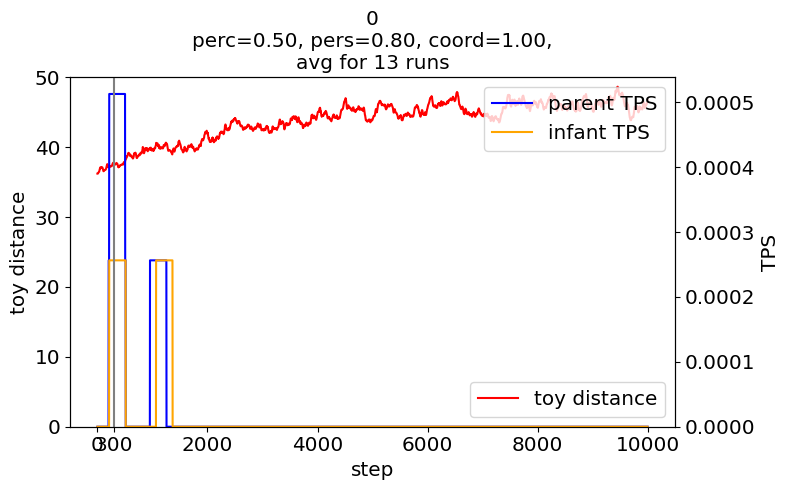

In [6]:
average_steps = 300

random_runs = np.random.choice(range(len(df)), size=1, replace=False)
for r in random_runs:
    visualize_run(df.iloc[r, :], extra_title=str(r), average_steps=average_steps)

## 1. Using steps required to reach emergent action as a metric

### Add new column, which determines if the run was successful and if so - in how many steps the goal has been achieved

In [10]:
df["success_steps"] = df.apply(
    lambda row: get_success_step(row["goal_distance"], SUCCESS_DIST), axis=1
)
df.sort_values(by=["success_steps"]).head(16)

perception  persistence  coordination  repeats  iterations  \
15    0.900000     0.000000      0.100000       11       15000   
27    0.633333     0.366667      0.100000       11       15000   
31    0.633333     0.000000      0.100000       11       15000   
11    0.900000     0.366667      0.100000       11       15000   
23    0.633333     0.433333      0.100000       11       15000   
7     0.900000     0.433333      0.000000       11       15000   
30    0.633333     0.100000      0.366667       11       15000   
47    0.366667     0.100000      0.100000       11       15000   
19    0.633333     0.700000      0.100000       11       15000   
3     0.900000     0.700000      0.100000       11       15000   
43    0.366667     0.366667      0.100000       11       15000   
39    0.366667     0.433333      0.100000       11       15000   
10    0.900000     0.366667      0.366667       11       15000   
14    0.900000     0.000000      0.366667       11       15000   
0     0.900000     0.900000      0.900000       11       15000   
1     0.900000     0.900000      0.633333       11       15000   

                                        goal_distance  \
15  [36.160820030176815, 36.160820030176815, 36.15...   
27  [36.058102049644326, 36.058102049644326, 36.05...   
31  [36.10495501916605, 36.10495501916604, 36.1288...   
11  [35.98382655350573, 35.98382655350573, 35.9850...   
23  [35.85149045507967, 35.85149045507967, 35.8501...   
7   [36.22922171061668, 36.22922171061668, 36.2172...   
30  [35.79082090815256, 35.79082090815256, 35.8000...   
47  [36.09651950793614, 36.09651950793614, 36.0899...   
19  [36.14991388106114, 36.14991388106114, 36.1592...   
3   [36.206589466738414, 36.206589466738414, 36.21...   
43  [36.250849859894714, 36.250849859894714, 36.25...   
39  [36.43544148026676, 36.43544148026676, 36.4354...   
10  [36.126491707553015, 36.126491707553015, 36.14...   
14  [35.97042651559366, 35.97042651559366, 35.9666...   
0   [36.38576512405545, 36.38576512405545, 36.3969...   
1   [35.98344152290745, 35.98344152290745, 35.9814...   

                                           parent_tps  \
15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
27  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
31  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
30  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
47  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
39  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           infant_tps  success_steps  
15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          695.0  
27  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          822.0  
31  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          822.0  
11  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          895.0  
23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          895.0  
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          936.0  
30  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1312.0  
47  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1433.0  
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1595.0  
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1981.0  
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         2785.0  
39  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         8723.0  
10  [0.0, 0.0, 0.0

In [8]:
df.loc[:, "success_steps"].mean()

nan

### Show the histogram of minimum distance in each run, and histogram of the number of steps required to reach the goal

In [81]:
df.loc[:, "success_steps"].count()

874

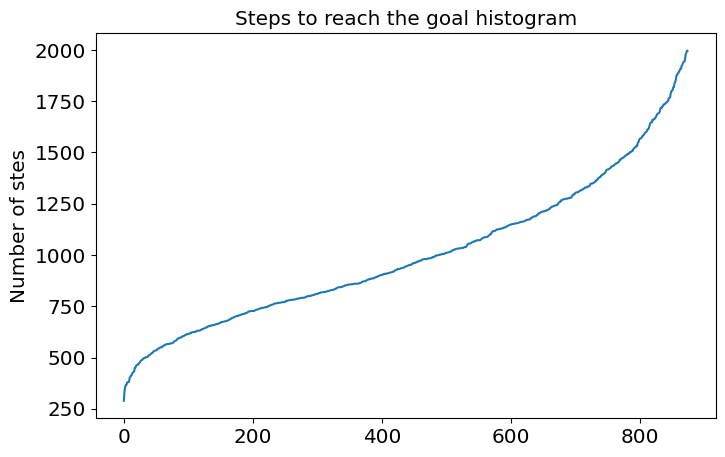

In [75]:
y = (
    df[df["success_steps"].notna()]
    .apply(lambda row: np.min(row["success_steps"]), axis=1)
    .sort_values()
    .to_numpy()
)

fig, ax = plt.subplots()
ax.plot(y)
ax.set_title("Steps to reach the goal histogram")
ax.set_ylabel("Number of stes")
plt.show()

### See how the best run performed, for different number of steps used in calculating the moving average
(the grey vertical line shows the number of steps used for calculating the average)

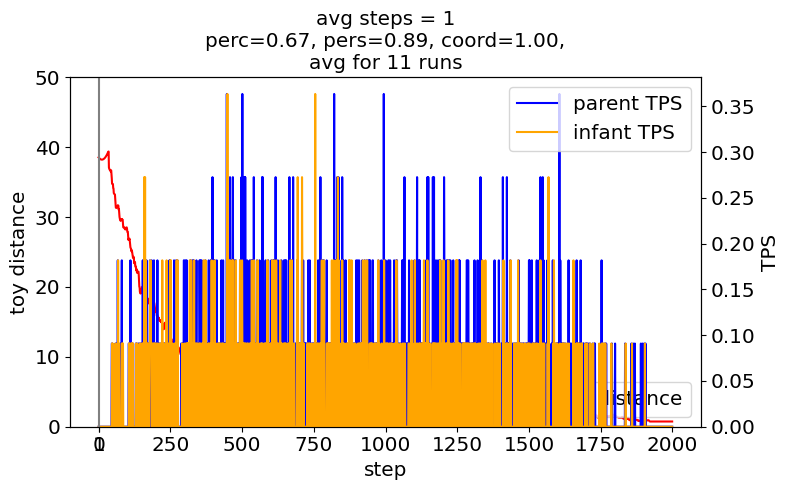

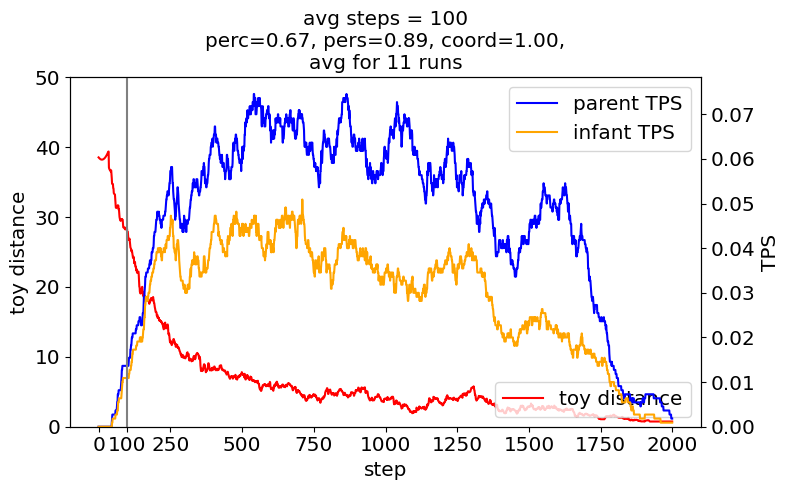

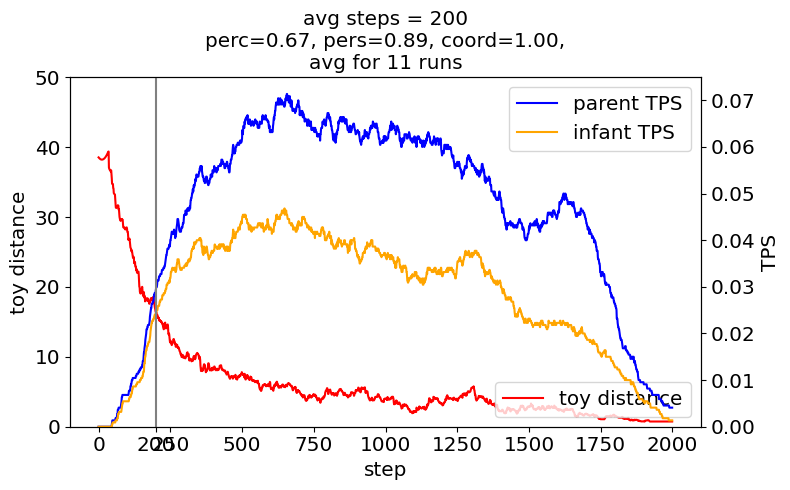

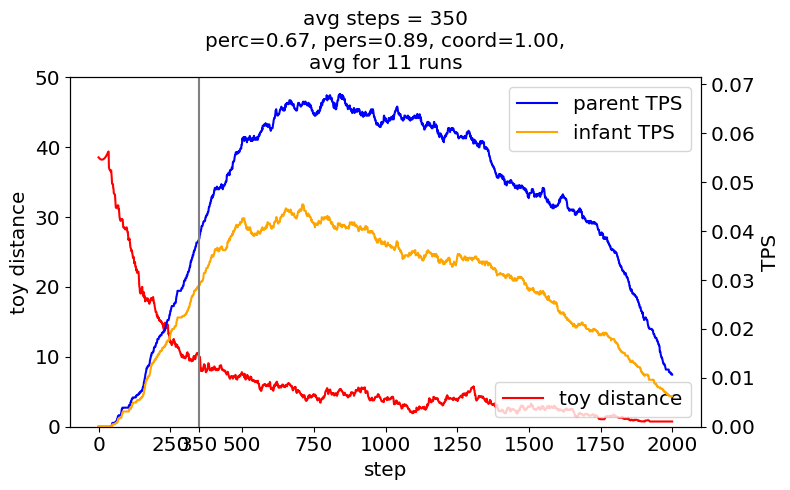

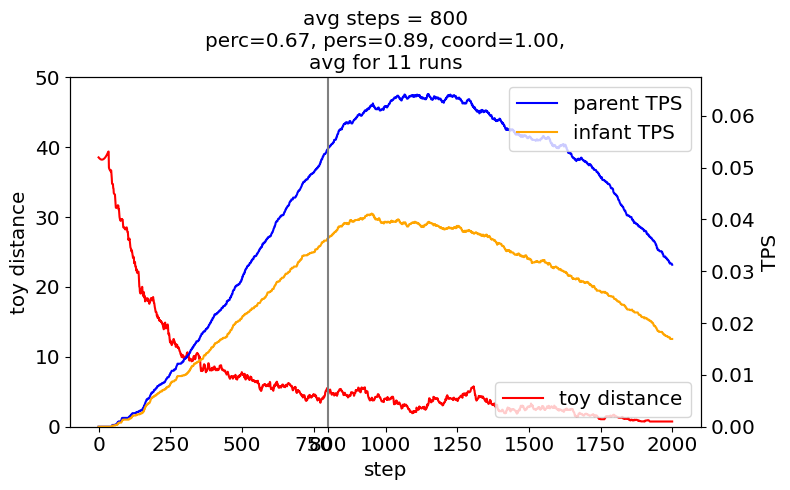

In [83]:
for steps in [1, 100, 200, 350, 800]:
    visualize_run(
        df.sort_values(by=["success_steps"]).iloc[0, :],
        average_steps=steps,
        extra_title=f"avg steps = {steps}",
    )

### Create heatmap for 2 variables
We define two ways of creating the heatmap:
1. Find 3 paramters which change the least in the top N runs and free the remaining two
2. Find the top 2 parameters that changed the least in the top N runs. Then group all data by those two parameters, averaging the remaining values - most importantly - the selected metric values

In [52]:
def get_heatmap_data_fixed(df, metric, top_runs_no, ascending=True):
    top_runs = df.sort_values(by=[metric], ascending=ascending).head(top_runs_no)

    params_data = []

    for param in ["perception", "persistence", "coordination"]:
        bincount = np.bincount(top_runs[param])
        count = np.max(bincount)
        value = np.argmax(bincount)

        params_data.append([param, value, count])

    params_df = pd.DataFrame(
        params_data, columns=["param", "best_value", "count"]
    ).sort_values("count", ascending=False)
    print(params_df)
    fixed_params = (
        params_df.head(1).loc[:, ["param", "best_value"]].to_numpy().reshape(2)
    )
    free_params = (
        params_df.tail(2).loc[:, ["param", "best_value"]].to_numpy().reshape(4)
    )

    p1, v1 = fixed_params
    param1, val1, param2, val2 = free_params

    selected_runs = df[(df[p1] == v1)]
    selected_runs = selected_runs.sort_values(by=[param1, param2])

    labels1 = selected_runs[param1].unique().round(3)
    labels2 = selected_runs[param2].unique().round(3)

    hm_data = selected_runs[metric].to_numpy().reshape(len(labels1), len(labels2)).T

    return hm_data, fixed_params, [param1, param2], [labels1, labels2]

In [48]:
def create_heatmap(heatmap_data, labelsx, labelsy, invert_colors=False, title=""):
    assert heatmap_data.shape == (len(labelsy), len(labelsx))

    colormap_data = np.nan_to_num(heatmap_data, nan=(np.nanmax(heatmap_data) + 100))

    fig, ax = plt.subplots(figsize=(8, 8))

    if invert_colors:
        cmap = matplotlib.colormaps["viridis_r"]
    else:
        cmap = matplotlib.colormaps["viridis"]
    im = ax.imshow(colormap_data, cmap=cmap)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labelsx)), labels=labelsx)
    ax.set_yticks(np.arange(len(labelsy)), labels=labelsy)

    ax.set_xlabel(param1)
    ax.set_ylabel(param2)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labelsx)):
        for j in range(len(labelsy)):
            text = ax.text(
                i,
                j,
                heatmap_data[j, i],
                ha="center",
                va="center",
                color="w",
                fontsize=14,
            )

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

### Show the heatmap for the fixed 3 parameters, which were the most common in the top 30 runs

          param  best_value  count
2  coordination           0     30
0    perception           0     25
1   persistence           0     21


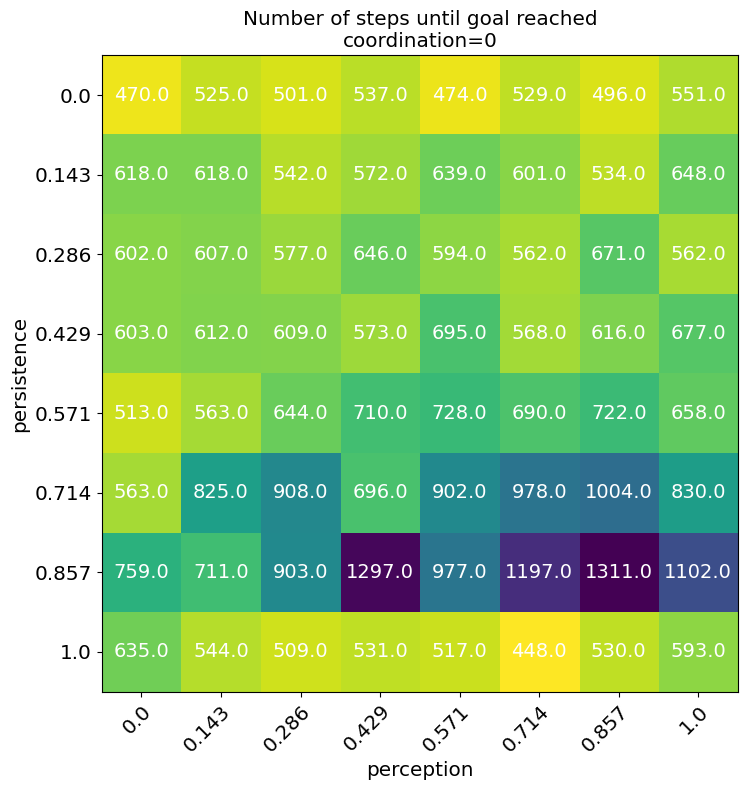

In [53]:
(
    hm_data,
    [p1, v1],
    [param1, param2],
    [labels1, labels2],
) = get_heatmap_data_fixed(df, "success_steps", top_runs_no=30)
title = f"Number of steps until goal reached\n{p1}={v1}"
create_heatmap(hm_data, labels1, labels2, invert_colors=True, title=title)

## Using TPS (third-party state) measure as a metric

Let's define two metrics - maximum TPS throughout the run, and TPS at the end of the run. 
Both values will be calculated using the moving average.
We will measure the TPS for parent and infant separately.

In [23]:
average_steps = 500

In [15]:
def moving_average(a, n=3):
    # Add zeros at the beginning, so the result doesn't change dimensions
    a = np.concatenate([([0] * (n - 1)), a])

    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

In [24]:
df_tps = df.copy()

df_tps["parent_tps_max"] = df.apply(
    lambda row: moving_average(row["parent_satisfaction"], n=average_steps).max(),
    axis=1,
)
df_tps["parent_tps_end"] = df.apply(
    lambda row: moving_average(row["parent_satisfaction"], n=average_steps)[-1], axis=1
)
df_tps["infant_tps_max"] = df.apply(
    lambda row: moving_average(row["infant_satisfaction"], n=average_steps).max(),
    axis=1,
)
df_tps["infant_tps_end"] = df.apply(
    lambda row: moving_average(row["infant_satisfaction"], n=average_steps)[-1], axis=1
)

In [25]:
new_df = df_tps.groupby(["coordination", "precision"]).mean(numeric_only=True)
new_df

width  height  speed  lego_count  exploration  \
coordination precision                                                  
0.0          20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
25.0         20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
50.0         20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
75.0         20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   
100.0        20.0       300.0   300.0    2.0         4.0         50.0   
             40.0       300.0   300.0    2.0         4.0         50.0   
             60.0       300.0   300.0    2.0         4.0         50.0   
             80.0       300.0   300.0    2.0         4.0         50.0   
             100.0      300.0   300.0    2.0         4.0         50.0   

                        responsiveness  relevance  repeats  max_iter  \
coordination precision                                                 
0.0          20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
25.0         20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
50.0         20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
75.0         20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   
100.0        20.0                 50.0       50.0    100.0    5000.0   
             40.0                 50.0       50.0    100.0    5000.0   
             60.0                 50.0       50.0    100.0    5000.0   
             80.0                 50.0       50.0    100.0    5000.0   
             100.0                50.0       50.0    100.0    5000.0   

                        success_steps  parent_tps_max  parent_tps_end  \
coordination precision            

### Repeat all of the above, using the four newly created metrics
For each metric (`tps_max` / `tps_end`), (`parent` / `infant`) plot the run with the best result and the two types of heatmap

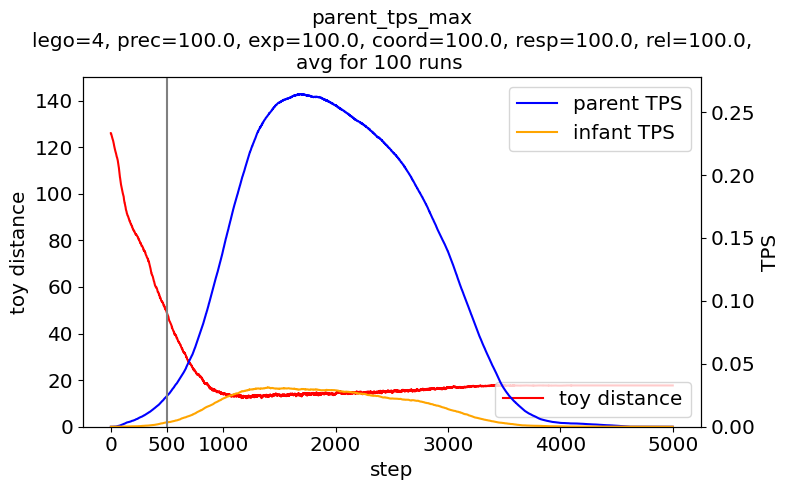

            param  best_value  count
2       relevance         100     30
3  responsiveness         100     30
0       precision         100     15
4    coordination         100     13
1     exploration          75     11


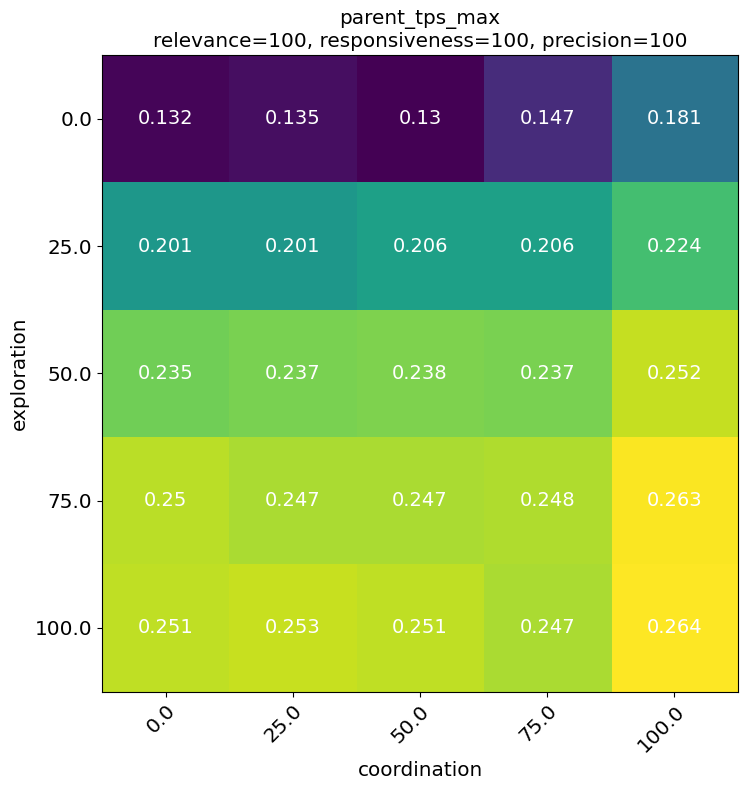

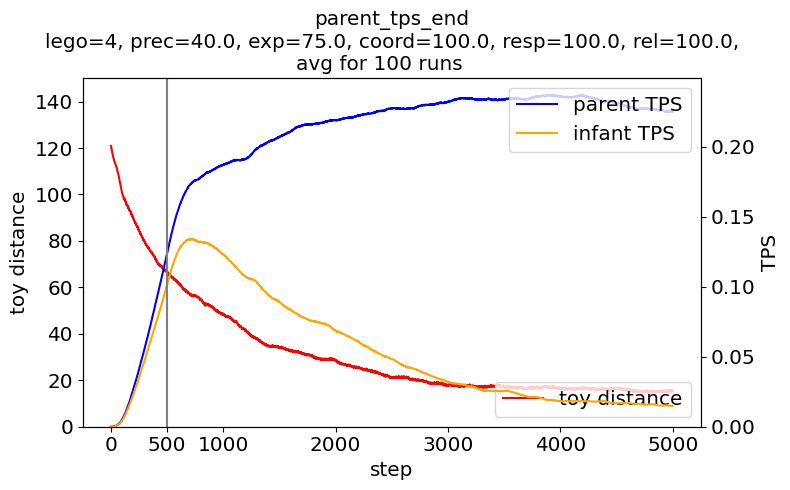

            param  best_value  count
2       relevance         100     30
3  responsiveness         100     19
4    coordination         100     18
0       precision          20     15
1     exploration          50      9


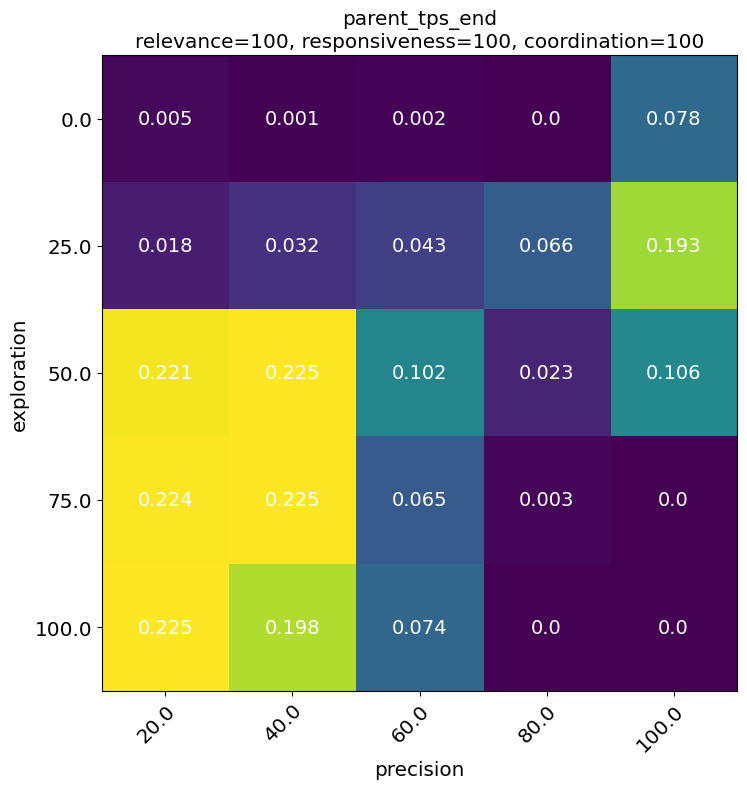

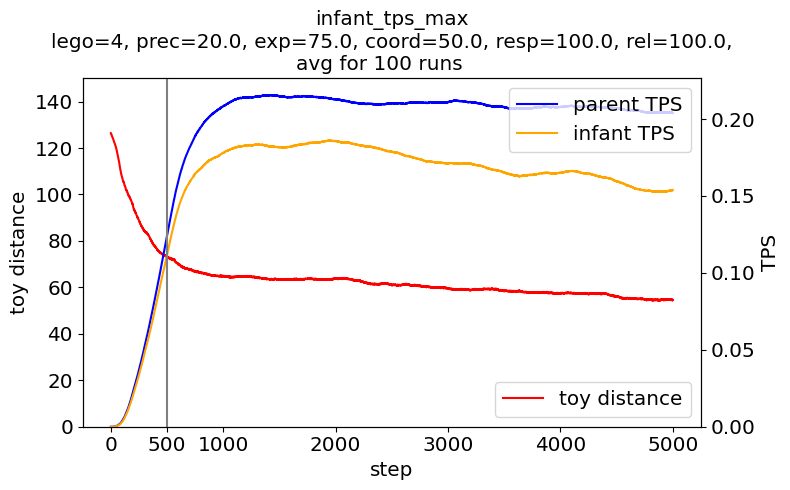

            param  best_value  count
3  responsiveness         100     30
0       precision          20     24
4    coordination         100     18
2       relevance         100     16
1     exploration          50      8


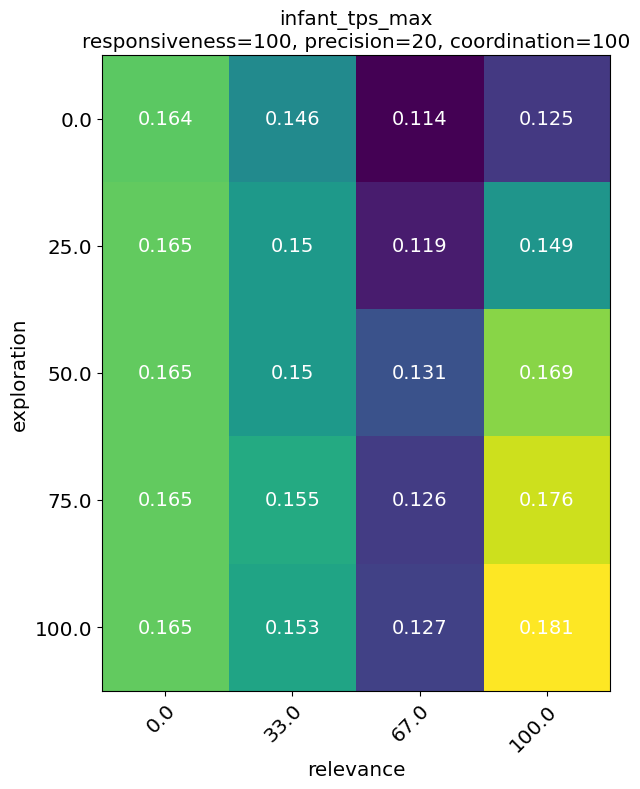

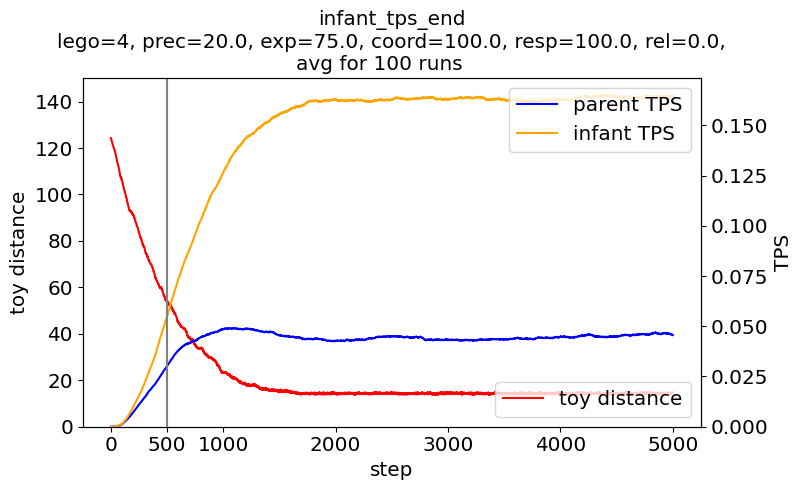

            param  best_value  count
3  responsiveness         100     30
4    coordination         100     24
0       precision          20     16
2       relevance           0     15
1     exploration          75      9


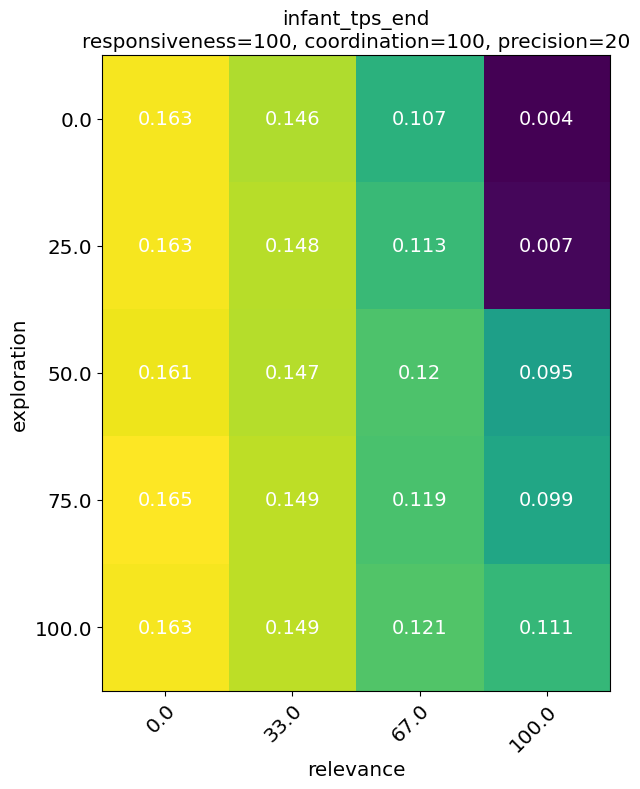

In [30]:
for agent in ["parent", "infant"]:
    for kind in ["max", "end"]:
        metric = agent + "_tps_" + kind
        visualize_run(
            df_tps.sort_values(by=[metric], ascending=False).iloc[0, :],
            average_steps=average_steps,
            extra_title=metric,
        )

        (
            hm_data,
            [p1, v1, p2, v2, p3, v3],
            [param1, param2],
            [labels1, labels2],
        ) = get_heatmap_data_fixed(df_tps, metric, top_runs_no=30, ascending=False)
        title = f"{metric}\n{p1}={v1}, {p2}={v2}, {p3}={v3}"
        create_heatmap(hm_data.round(3), labels1, labels2, title=title)